In [1]:
import pandas as pd
import numpy as np
from datetime import date, timedelta
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.axes as ax
import openpyxl
from openpyxl.styles import Border, Side, PatternFill, Font, GradientFill, Alignment
from openpyxl.drawing.image import Image
import win32com.client as win32
import os
from PIL import ImageGrab
import win32com.client

olApp = win32.Dispatch('Outlook.Application')
olNS = olApp.GetNameSpace('MAPI')

import sys
sys.path.append("C:\\Users\\KlimovaAnnaA\\Documents\\MyFiles\\Projects\\OCP")
from Defs import merge_SalesUnits
from Defs import merge_Mapping
from Defs import Period
from Defs import new_list
from Defs import export_from_RISKCUSTOM
from Defs import add_in_currency_column
from Defs import concat_columns
from Defs import export_from_WHWEEK

In [100]:
Today = '2024-06-30'

print_to_excel = True

C:\Users\KlimovaAnnaA\Documents\MyFiles\Projects\OCP\Defs.py:179: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data_export = pd.read_sql(query, con=connection)
C:\Users\KlimovaAnnaA\Documents\MyFiles\Projects\OCP\Defs.py:98: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data_export = pd.read_sql(query, con=connection)
C:\Users\KlimovaAnnaA\AppData\Local\Temp\ipykernel_7020\58017352.py:23: FutureWarning: The provided callable <built-in function sum> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  data_unifiedOcp_pivot = data_work_query.pivot_table(index

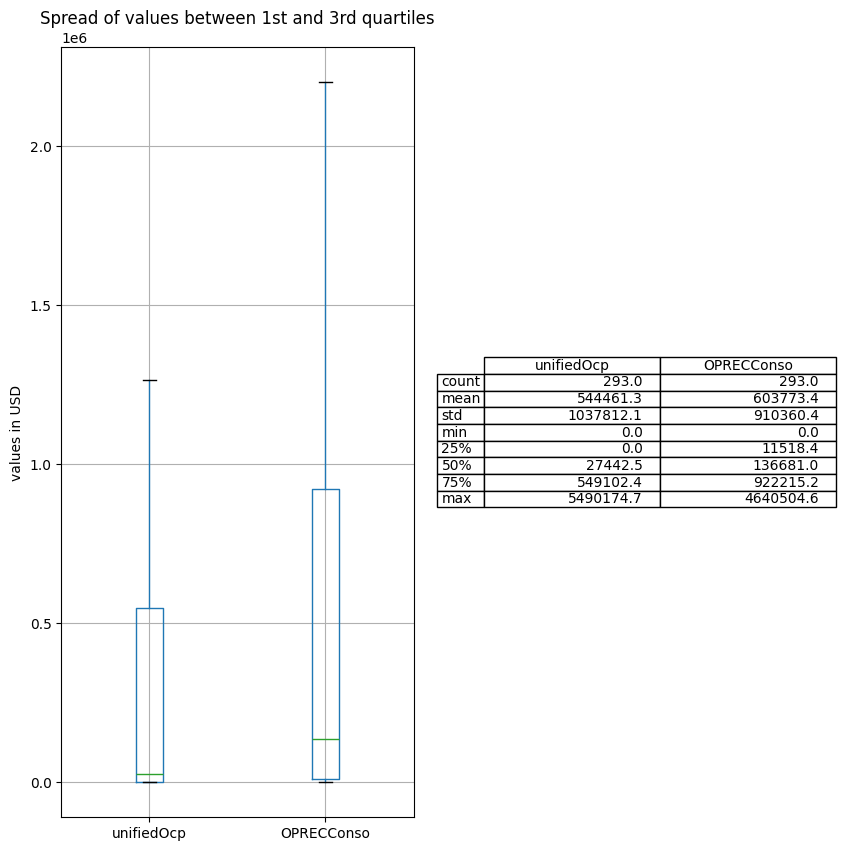

In [103]:
query = f"""
select * 
from xxwh."OPRECConso_detailed"
where "periodDate" = TO_DATE('{Today}', 'YYYY-MM-DD')
and "rowType" = 'on hand'
"""
data_OPRECConso_detailed = export_from_WHWEEK(query)
data_OPRECConso_detailed_work = data_OPRECConso_detailed.loc[data_OPRECConso_detailed['##inserted'] == data_OPRECConso_detailed['##inserted'].max(), ['productGroupNine','businessUnit','dealCurrency','quantity','dealAmount']]
# merge segments
# data_OPRECConso_detailed_work['businessSegment'] = merge_SalesUnits(data_OPRECConso_detailed_work,'businessUnit',merge_col='ocpSegment')

query = f"""
select * 
from "RISKACCESS"."unifiedOcp"
where "reportDate" = TO_DATE('{Today}', 'YYYY-MM-DD')
and "sourceTable" = 'unifiedMaterialMovementSlice_inventory'
"""
data = export_from_RISKCUSTOM(query)
data_work = data[['sourceTable','accountName','holding','buCode','ocpSegment','volumeUsd','salesUnitsId']]

intersection_list = set(data_OPRECConso_detailed_work.productGroupNine.tolist()).intersection(set(data_work.accountName.tolist()))
data_work_query = data_work[data_work.accountName.isin(intersection_list)]
data_unifiedOcp_pivot = data_work_query.pivot_table(index=['holding','buCode','accountName','sourceTable'], values='volumeUsd',aggfunc=sum).reset_index()
data_OPRECConso_query = data_OPRECConso_detailed_work[(data_OPRECConso_detailed_work.productGroupNine.isin(intersection_list))]
data_OPRECConso_pivot = data_OPRECConso_query.pivot_table(index=['businessUnit','productGroupNine'], values=['dealAmount', 'quantity'],aggfunc=sum).reset_index()

data_USD_merge = data_unifiedOcp_pivot.merge(data_OPRECConso_pivot, how='outer', left_on=['buCode','accountName'], right_on=['businessUnit','productGroupNine'])[['sourceTable','holding','buCode','accountName','volumeUsd','dealAmount','quantity']].rename(columns={'volumeUsd':'unifiedOcp','dealAmount':'OPRECConso'}).sort_values(['unifiedOcp','OPRECConso'], ascending=False)


data_USD_merge[['unifiedOcp', 'OPRECConso']] = data_USD_merge[['unifiedOcp', 'OPRECConso']].apply(lambda x: x.abs())


### graphics
values_list = ['unifiedOcp', 'OPRECConso']
clear_data_dict = {}
for value in values_list:
    Q3 = data_USD_merge[value].quantile(0.75)
    Q1 = data_USD_merge[value].quantile(0.25)
    IQR =  Q3-Q1
    lower_bond = Q1 - 1.5*IQR
    upper_bond = Q3 + 1.5*IQR
    data_clear = data_USD_merge[(data_USD_merge[value]<=upper_bond)&(data_USD_merge[value]>=lower_bond)]
    clear_data_dict[value] = data_clear
df_plots = clear_data_dict['unifiedOcp'].merge(clear_data_dict['OPRECConso'], how='inner')

fig, axes = plt.subplots(ncols=2, figsize=(10,10))
df_plots[['unifiedOcp', 'OPRECConso']].boxplot(ax=axes[0], showfliers=False)
axes[0].set_ylabel('values in USD')
axes[0].set_title('Spread of values between 1st and 3rd quartiles')

table_describe = round(df_plots[['unifiedOcp', 'OPRECConso']].describe(),1)
axes[1].axis('off')
axes[1].table(cellText=table_describe.values, colLabels=table_describe.columns, rowLabels=table_describe.index, loc='center')

# diff
data_USD_merge[['unifiedOcp','OPRECConso']] = data_USD_merge[['unifiedOcp','OPRECConso']].fillna(0)
data_USD_merge['huge_diff'] = (data_USD_merge.unifiedOcp.abs()/data_USD_merge.OPRECConso.abs() < 0.7) | (data_USD_merge.unifiedOcp.abs()/data_USD_merge.OPRECConso.abs() > 1.30)
data_USD_merge = data_USD_merge[~((data_USD_merge.unifiedOcp==0)&(data_USD_merge.OPRECConso==0))]


### to excel
if print_to_excel == True:
    plt.savefig('Differences.png')

    Output_file = f'{str(date.today())}_unifiedOcp_vs_OPRECConso.xlsx'
    writer = pd.ExcelWriter(Output_file, engine='openpyxl')
    
    data_USD_merge.to_excel(writer, index=False, sheet_name='diff')

    worksheet = writer.sheets['diff']
    img = openpyxl.drawing.image.Image('Differences.png')
    img.anchor = 'K6'
    worksheet.add_image(img)

    data_work.to_excel(writer, sheet_name='unifiedOcp')
    data_OPRECConso_detailed_work.to_excel(writer, sheet_name='OPRECConso')   

    writer.close() 


In [88]:
data_USD_merge[data_USD_merge.huge_diff==False]
# data_USD_merge[data_USD_merge.huge_diff==True]
#`b`
# data_USD_merge[(data_USD_merge.unifiedOcp==0)&(data_USD_merge.OPRECConso==0)]
data_USD_merge.tail(30)

,sourceTable,holding,buCode,accountName,unifiedOcp,OPRECConso,quantity,huge_diff
323,unifiedMaterialMovementSlice_inventory,EUROCHEM,RUFSF,SODIUM HYPOCHLORITE,0.0,2.758254e+03,8.364000,True
386,unifiedMaterialMovementSlice_inventory,EUROCHEM,RUNEV,OTHER INDUSTRIAL GASES,0.0,2.173528e+03,-21.000000,True
341,unifiedMaterialMovementSlice_inventory,EUROCHEM,RUNAK,CALCIUM CHLORIDE SOLID,0.0,1.122896e+03,3.374000,True
21,unifiedMaterialMovementSlice_inventory,EUROCHEM,AREFO,OTHER CHLOR ALCALI,0.0,8.301892e+02,2.275000,True
350,unifiedMaterialMovementSlice_inventory,EUROCHEM,RUNAK,NITRIC ACID,0.0,5.601064e+02,4806.708000,True
345,unifiedMaterialMovementSlice_inventory,EUROCHEM,RUNAK,HYDROCHLORIC ACID,0.0,4.846140e+02,2.180000,True
180,unifiedMaterialMovementSlice_inventory,EUROCHEM,GREAH,OTHER PRODUCTS,0.0,3.894015e+02,25.069460,True
217,unifiedMaterialMovementSlice_inventory,EUROCHEM,LTLIF,INHIBITOR,0.0,3.069284e-02,5.434610,True
226,unifiedMaterialMovementSlice_inventory,EUROCHEM,LTLIF,SODIUM HYDROXIDE,0.0,2.722144e-02,79.588290,True
221,unifiedMaterialMovementSlice_inventory,EUROCHEM,LTLIF,NITRIC ACID,0.0,1.383987e-02,57.154000,True


Text(0, 0.5, 'Values in USD')

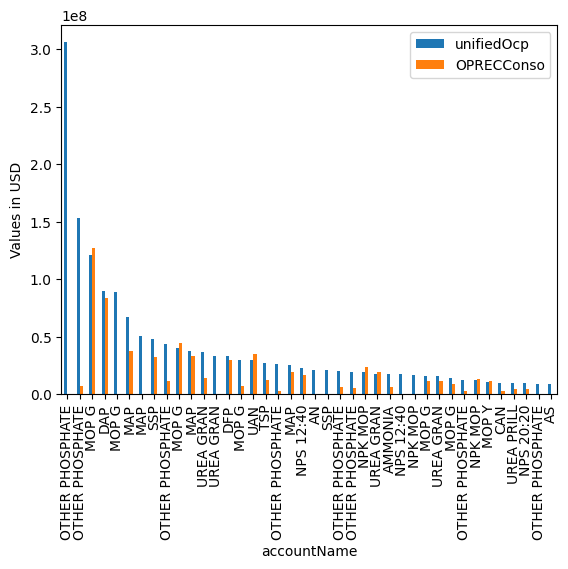

In [40]:
# data_USD_merge[(data_USD_merge.unifiedOcp>4*10^6) & (data_USD_merge.OPRECConso>4*10^6)].head(30)

fig, ax = plt.subplots()
df_plots.head(40).plot(kind='bar', x='accountName', y=['unifiedOcp','OPRECConso'], ax=ax)
plt.ylabel('Values in USD')

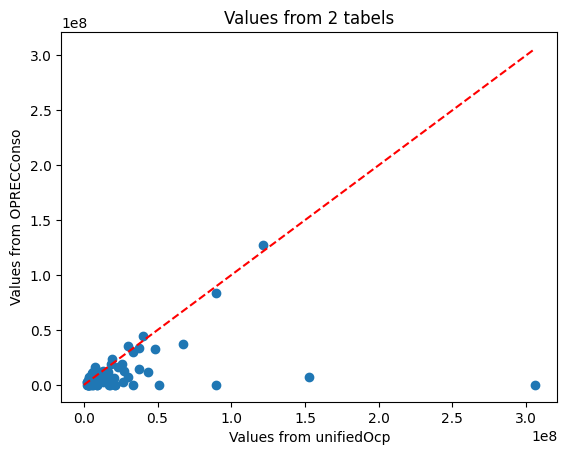

In [41]:


fig, ax = plt.subplots()
ax.scatter(df_plots.unifiedOcp, df_plots.OPRECConso)
max_val = max(df_plots.unifiedOcp.max(), df_plots.OPRECConso.max())
plt.xlabel('Values from unifiedOcp')
plt.ylabel('Values from OPRECConso')
plt.title('Values from 2 tabels')
plt.plot([0, max_val],[0, max_val], color='red', linestyle='--')
plt.show()

In [108]:
data_OPRECConso_pivot.shape
# data_unifiedOcp_pivot.info()

(382, 4)